In [1]:
import lightkurve as lk
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import astropy.units as u
%matplotlib inline

In [2]:
# Kep78 Info, In Days
kep78b_period = 8.5202/24
kep78b_duration = 0.814/24
kep78b_spacing = 0.01 * (kep78b_period ** 2 / (4.1 * 365)) 
kep78b_period_range = np.arange((kep78b_period - 1/24), (kep78b_period + 1/24), kep78b_spacing) 
usp_period_range = np.arange(8/24, 1, 0.00001) 
sp_period_range = np.arange(1, 10, 0.0001) 

In [3]:
def obtainData(quarter=None, write_meta=True, *args, **kwargs):
    results = lk.search_lightcurve(*args, **kwargs)
    if write_meta: 
        results.table.write("DataTable.csv", format="ascii.csv", overwrite=True)
    if quarter is None:
        return results.download_all().stitch()
    else:
        return results[quarter].download()

In [4]:
def produceBLSPeriodogramPlots(lc, period, duration, is_78b=False):
    periodogram = lc.to_periodogram(method="bls", period=period, duration=duration, frequency_factor=1e100) # Bug that required frequency_factor to be large
    best = periodogram.period_at_max_power

    # 1) Plotting the original SAP Light curves
    lc.plot(label="SAP FLUX")
    plt.title("Light Curve", fontsize=10)
    plt.xlabel("Time (Days)", fontsize=10)
    plt.ylabel("Flux", fontsize=10)
    plt.legend()

    # 2) Plotting the BLS periodogram
    periodogram.plot(label="BLS Periodogram")
    if is_78b:
        plt.axvline(kep78b_period, color="r", label="Period of Kepler-78b from the Literature", linestyle="--")
    plt.title("Box Least Squares Periodogram", fontsize=10)
    plt.xlabel("Period (Days)", fontsize=10)
    plt.ylabel("BLS Power", fontsize=10)
    plt.legend()

    return best

Text(0.5, 1.0, 'Light Curve of Kepler-78b')

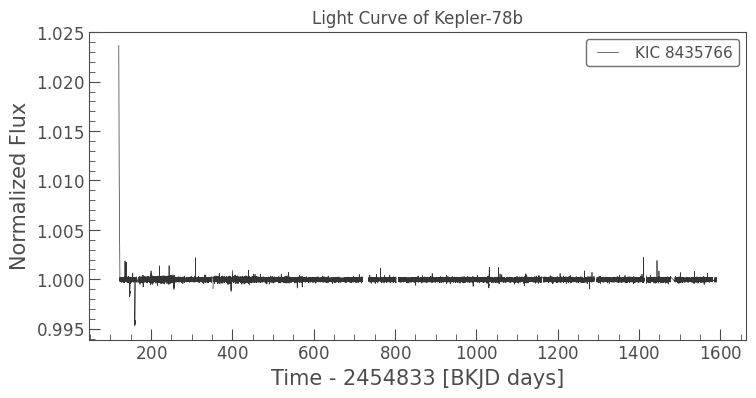

In [5]:
target = "Kepler-78b"
target_duration = kep78b_duration
target_period_range = kep78b_period_range
lc = obtainData(quarter=None, write_meta=False, target=target, mission="Kepler", exptime="long")
lc, trend = lc.flatten(return_trend=True)
baseline = lc.time[-1] - lc.time[0]
lc.plot()
plt.title(f"Light Curve of {target}")

Period of Kepler-78b obtained from BLS periodogram: 0.355008085679838 d or 8.520194056316111 h


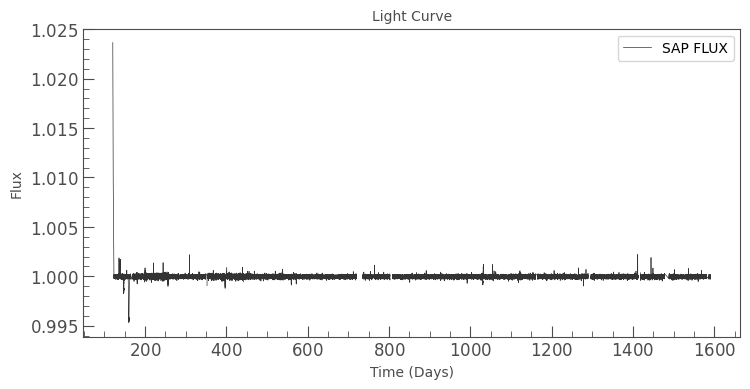

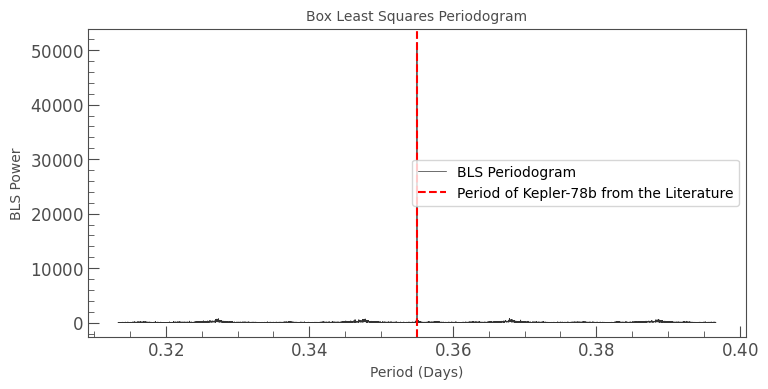

In [6]:
period = produceBLSPeriodogramPlots(lc, target_period_range, target_duration, is_78b=True)
print(f"Period of Kepler-78b obtained from BLS periodogram: {period} or {period * 24 / u.day * u.hour}")

spacing = 0.001 * (period.value ** 2 / (4.1 * 365)) 
period_grid = np.arange(period.value-spacing*100, period.value+spacing*99, spacing)

plt.show()

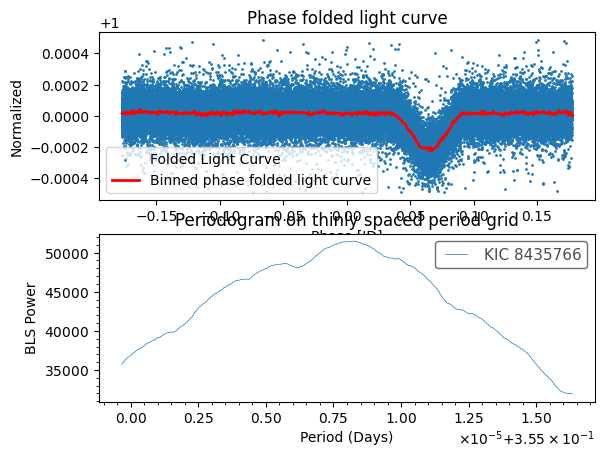

In [7]:
folded_lc = lc.fold(period).remove_outliers()
binsize = int(baseline.value/period.value)
binned_lc = folded_lc.bin(time_bin_size=0.001, aggregate_func=np.nanmedian)

periodogram = lc.to_periodogram(method="bls", period=period_grid, duration=kep78b_duration, frequency_factor=1e100)

fig, (ax1, ax2) = plt.subplots(2, 1)
plt.rcParams['figure.figsize'] = [12, 20]

plt.subplot(2, 1, 1)
folded_lc.scatter(ax=ax1, label="Folded Light Curve")
binned_lc.plot(lw=2, color='r', ax=ax1, label="Binned phase folded light curve")
plt.title("Phase folded light curve")
plt.xlabel("Phase [JD]")
plt.ylabel("Normalized")
plt.legend()

plt.subplot(2, 1, 2)
periodogram.plot(ax=ax2)
plt.title("Periodogram on thinly spaced period grid")
plt.xlabel("Period (Days)")
plt.ylabel("BLS Power")

plt.show()